![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Redes Neuronales

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de redes neuronales de una capa y multicapa. El taller está constituido por 4 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción probabilidad de admisión a la universidad

En este taller se usará el conjunto de datos de admisiones a una universidad proveniente de la base de datos de Kaggle. Cada observación contiene la probabilidad de que un estudiante sea admitido por la universidad, dadas distintas variables predictoras como el puntaje del examén TOEFL y GRE, el promedio (GPA), entre otras. El objetivo es predecir la probabilidad de admissión de cada estudiante. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/mohansacharya/graduate-admissions).

Punto 1. Se entrena una red neuronal de una capa con la librería Keras y se justifica el uso de la función de perdida, el optimizador y/o el número de épocas. Además, se grafica la pérdida del modelo vs el número de épocas y se presenta el desempeño del modelo con las métricas de error absoluto medio (MAE) y error cuadrático medio (MSE). [5 puntos]

Punto 2. Se entrena una red neuronal de dos capas con la librería Keras y se justifica el uso de la función de perdida, el optimizador, el número de épocas y/o el número de neuronas. Además, se grafica la pérdida del modelo vs el número de épocas y se presenta el desempeño del modelo con las métricas de error absoluto medio (MAE) y error cuadrático medio (MSE). [5 puntos]

Punto 3. Se entrena una red neuronal de más de una capa con la librería Keras, usando dropout y early stopping, y se justifica el uso de la función de perdida, el optimizador, el número de épocas y/o el número de neuronas. Además, se grafica la pérdida del modelo vs el número de épocas y se presenta el desempeño del modelo con las métricas de error absoluto medio (MAE) y error cuadrático medio (MSE). [5 puntos]

Punto 4. Se comparan los resultados de desempeño obtenidos con las diferentes redes implementadas, y se comentan las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño. [5 puntos]

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import numpy as np
import keras 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import optuna
keras.utils.set_random_seed(812)

plt.style.use('ggplot')

In [3]:
# Carga de datos de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/universityGraduateAdmissions.csv', index_col=0)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


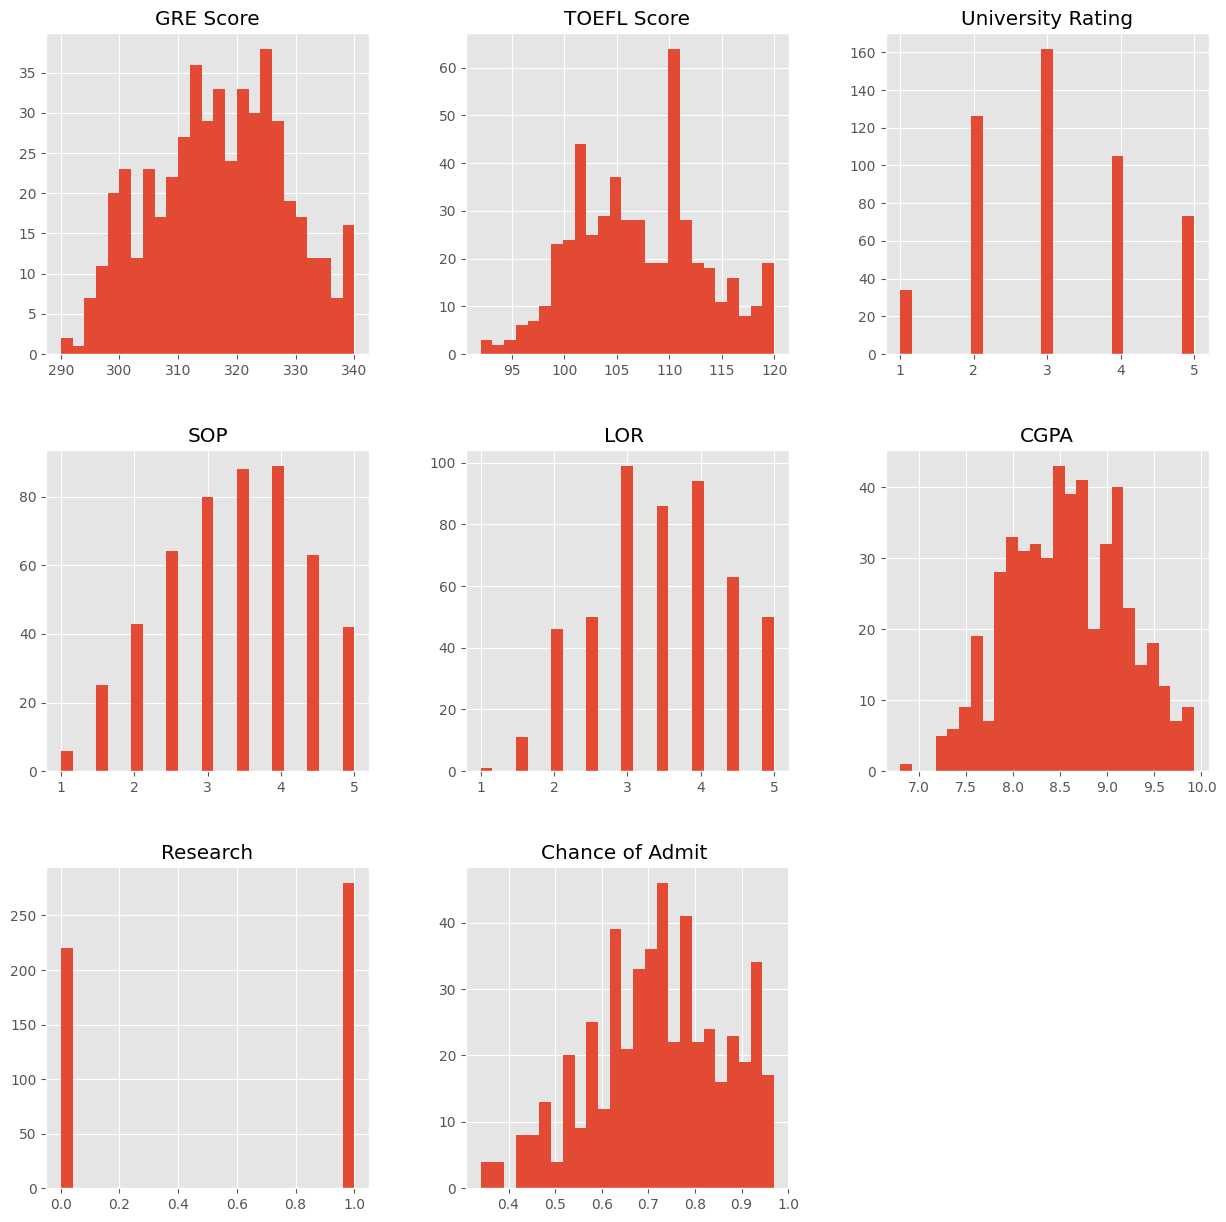

In [4]:
# Hitogramas de las varaibles del dataset
data.hist(bins=25, figsize=(15,15))
plt.show()

In [5]:
# Definición de variables predictoras (X)
X = data.drop(data.columns[-1], axis=1)
# Definición de variable de interés (y)
Y = data[data.columns[-1]]

Se realiza el procesamiento de los datos, utilizando un StandardScaler de la libreria sklearn

In [6]:
from sklearn.preprocessing import StandardScaler

# Normaliza los features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X_scaled, Y, test_size=0.3, random_state=22)

## Punto 1 - Red Neuronal de una capa

En la celda 1 creen una **red neuronal de una capa** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes, usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador y el número de épocas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

A continuación se crean las funciones que primero crean el modelo utilizando una capa de entrada con las dimensiones del conjunto de datos, una capa intermedia donde se realizar un ajuste para encontrar el mejor número de neuronas de la capa, y por último una capa de salidad con una sola neurona.

In [8]:
def create_model(trial):

    # DEF ESTRUCTURA DEL MODELO 
    model = Sequential([
        Input(shape=(X.shape[1], )), # CAPA ENTRADA
        Dense(units=trial.suggest_int('units', 16, 256), activation='relu'), # CAPA OCULTA
        Dense(units=1) # CAPA SALIDA
    ])

    return model

Luego, se procede a realizar el ajuste de hiperparametros del modelo utilizando optuna para hallar los mejores parametros como la función de perdidad, el optimizador y el número de epocas. Para el ajuste del modelo se utiliza un `validation_split=0.15` que corresponde a que se ejecuta la validación en cada epoca del 15% de los datos de entrenamiento, por último se almacena el desempeño del modelo utilizando el set de test y la métrica MSE.

In [9]:
def objective(trial):

    model = create_model(trial)

    optimizer = trial.suggest_categorical('optimizer', ['rmsprop', 'adam', 'sgd'])

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error']
                  )

    history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=trial.suggest_int('epochs', 50, 300), verbose=0)
    results = model.evaluate(xTest, yTest, verbose=0)

    result = results[1] # RETORNA MSE

    return result

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-05-12 11:02:28,286] A new study created in memory with name: no-name-14283a8a-ebb4-41d5-a9f7-c74dedc9b714
[I 2024-05-12 11:02:46,708] Trial 0 finished with value: 0.0035884324461221695 and parameters: {'units': 244, 'optimizer': 'sgd', 'epochs': 282}. Best is trial 0 with value: 0.0035884324461221695.
[I 2024-05-12 11:02:55,270] Trial 1 finished with value: 0.006911636795848608 and parameters: {'units': 18, 'optimizer': 'sgd', 'epochs': 131}. Best is trial 0 with value: 0.0035884324461221695.
[I 2024-05-12 11:03:07,553] Trial 2 finished with value: 0.005137374624609947 and parameters: {'units': 179, 'optimizer': 'adam', 'epochs': 178}. Best is trial 0 with value: 0.0035884324461221695.
[I 2024-05-12 11:03:19,967] Trial 3 finished with value: 0.005555934272706509 and parameters: {'units': 92, 'optimizer': 'rmsprop', 'epochs': 184}. Best is trial 0 with value: 0.0035884324461221695.
[I 2024-05-12 11:03:26,524] Trial 4 finished with value: 0.004716881550848484 and parameters: {'un

De los resultados de optuna se obtiene los mejores parámetros de la red que serán utilizados para realizar las prediciones. 

In [10]:
print(f'best params: {study.best_params}\nduration: {study.trials_dataframe()["duration"].sum().total_seconds()}')

best params: {'units': 244, 'optimizer': 'sgd', 'epochs': 282}
duration: 140.041616


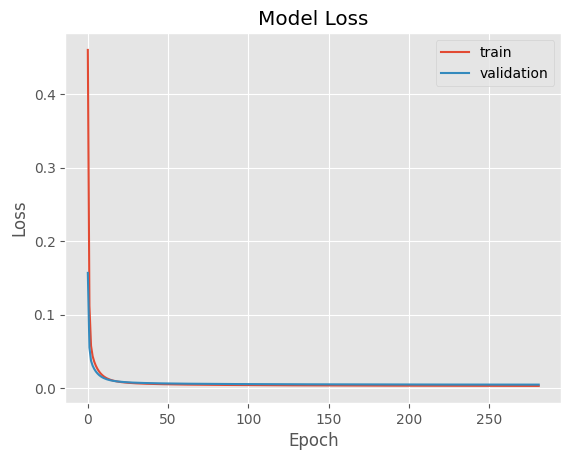

In [11]:
model = create_model(study.best_trial)
model.compile(optimizer=study.best_trial.params['optimizer'],
              loss='mse',
              metrics=['mean_squared_error'])

history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=study.best_trial.params['epochs'], verbose=0)

# Gráfica de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

De la grafica de pérdida se puede decir lo siguiente:
-  La pérdida en ambos sets de train & validación disminuye rapidamente en la primeras epocas, esto podria indicar el modelo aprende eficazmente las caracteristicas subyacentes de los datos.
-  La pérdida en ambos sets se estabiliza y muestra poco cambio a medida que aumenta el número de epoca, lo que sugiere que el modelo alcanza una convergencia y que probablemente entrenar por más epocas no mejora el rendimiento de forma significativa, podria ser bueno utilizar un early stoping para esto. 
-  Lo proximidad de las lineas en ambos sets parece indicar que no existe un overfitting significativo, quiero decir que el modelo tiene buena capacidad de generalización con datos que no ha visto hasta el momento.

In [12]:
# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(xTest)
mae_one_layer = mean_absolute_error(yTest, y_pred)
mse_one_layer = mean_squared_error(yTest, y_pred)

print(f"MAE on Test Set: {mae_one_layer}")
print(f"MSE on Test Set: {mse_one_layer}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE on Test Set: 0.051172996759414675
MSE on Test Set: 0.004531440004119594


## Punto 2 - Red Neuronal multicapa

En la celda 2 creen una **red neuronal con dos capas** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

Se realiza un mismo procedimiento que el anterior solo que se realiza una pequeña modificación a la función `create_model` para que la estructura contenga dos capas ocultas en vez de una.

In [13]:
def create_model(trial):

    # DEF ESTRUCTURA DEL MODELO 
    model = Sequential([
        Input(shape=(X.shape[1], )), # CAPA ENTRADA
        Dense(units=trial.suggest_int('units1', 16, 256), activation='relu'), # CAPA OCULTA
        Dense(units=trial.suggest_int('units2', 16, 256), activation='relu'), # CAPA OCULTA
        Dense(units=1) # CAPA SALIDA
    ])

    return model

In [14]:
def objective(trial):

    model = create_model(trial)

    optimizer = trial.suggest_categorical('optimizer', ['rmsprop', 'adam', 'sgd'])

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error']
                  )

    history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=trial.suggest_int('epochs', 50, 300), verbose=0)
    results = model.evaluate(xTest, yTest, verbose=0)

    result = results[1] # RETORNA MSE

    return result

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-05-12 11:05:12,686] A new study created in memory with name: no-name-957be98c-4d32-4152-aa06-40ffb7ca860e
[I 2024-05-12 11:05:19,572] Trial 0 finished with value: 0.0044041587971150875 and parameters: {'units1': 227, 'units2': 120, 'optimizer': 'sgd', 'epochs': 87}. Best is trial 0 with value: 0.0044041587971150875.
[I 2024-05-12 11:05:29,678] Trial 1 finished with value: 0.006420785095542669 and parameters: {'units1': 214, 'units2': 253, 'optimizer': 'adam', 'epochs': 134}. Best is trial 0 with value: 0.0044041587971150875.
[I 2024-05-12 11:05:47,182] Trial 2 finished with value: 0.008161640726029873 and parameters: {'units1': 171, 'units2': 157, 'optimizer': 'adam', 'epochs': 280}. Best is trial 0 with value: 0.0044041587971150875.
[I 2024-05-12 11:05:59,690] Trial 3 finished with value: 0.004912109579890966 and parameters: {'units1': 37, 'units2': 25, 'optimizer': 'sgd', 'epochs': 202}. Best is trial 0 with value: 0.0044041587971150875.
[I 2024-05-12 11:06:11,948] Trial 4 fi

In [15]:
print(f'best params: {study.best_params}\nduration: {study.trials_dataframe()["duration"].sum().total_seconds()}')

best params: {'units1': 227, 'units2': 120, 'optimizer': 'sgd', 'epochs': 87}
duration: 111.788609


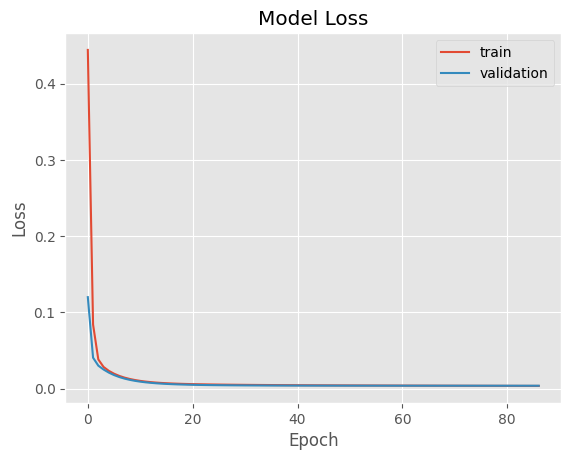

In [16]:
model = create_model(study.best_trial)
model.compile(optimizer=study.best_trial.params['optimizer'],
              loss='mse',
              metrics=['mean_squared_error'])

history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=study.best_trial.params['epochs'], verbose=0)

# Gráfica de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Son igualmente aplicables las conclusiones de la gráfica de pérdida para la red de una sola capa.

In [17]:
# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(xTest)
mae_two_layer = mean_absolute_error(yTest, y_pred)
mse_two_layer = mean_squared_error(yTest, y_pred)

print(f"MAE on Test Set: {mae_two_layer}")
print(f"MSE on Test Set: {mse_two_layer}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MAE on Test Set: 0.05427136980692545
MSE on Test Set: 0.004992447655527372


## Punto 3  - Red Neuronal multicapa

En la celda 3 creen **una red neuronal con más de una capa con la librería Keras, usando early stopping y dropout,** que prediga la probabilidad de admisión de los estudiantes con los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

In [18]:
def create_model(trial):

    # DEF ESTRUCTURA DEL MODELO 
    model = Sequential([
        Input(shape=(X.shape[1], )), # CAPA ENTRADA
        Dense(units=trial.suggest_int('units1', 16, 256), activation='relu'), # CAPA OCULTA
        Dropout(0.30),
        Dense(units=trial.suggest_int('units2', 16, 256), activation='relu'), # CAPA OCULTA
        Dropout(0.30),
        Dense(units=trial.suggest_int('units3', 16, 256), activation='relu'), # CAPA OCULTA
        Dropout(0.30),
        Dense(units=1) # CAPA SALIDA
    ])

    return model

In [19]:
def objective(trial):

    model = create_model(trial)

    optimizer = trial.suggest_categorical('optimizer', ['rmsprop', 'adam', 'sgd'])

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error']
                  )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=trial.suggest_int('epochs', 50, 300), verbose=0, callbacks=[early_stopping])
    results = model.evaluate(xTest, yTest, verbose=0)

    result = results[1] # RETORNA MSE

    return result

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-05-12 11:07:10,494] A new study created in memory with name: no-name-b703d06b-83ef-4146-94ae-90a78a3a82cd
[I 2024-05-12 11:07:15,542] Trial 0 finished with value: 0.005049271043390036 and parameters: {'units1': 185, 'units2': 227, 'units3': 196, 'optimizer': 'sgd', 'epochs': 68}. Best is trial 0 with value: 0.005049271043390036.
[I 2024-05-12 11:07:20,832] Trial 1 finished with value: 0.004329609218984842 and parameters: {'units1': 54, 'units2': 186, 'units3': 113, 'optimizer': 'rmsprop', 'epochs': 225}. Best is trial 1 with value: 0.004329609218984842.
[I 2024-05-12 11:07:23,360] Trial 2 finished with value: 0.015820562839508057 and parameters: {'units1': 134, 'units2': 30, 'units3': 215, 'optimizer': 'sgd', 'epochs': 102}. Best is trial 1 with value: 0.004329609218984842.
[I 2024-05-12 11:07:26,300] Trial 3 finished with value: 0.010273722931742668 and parameters: {'units1': 209, 'units2': 117, 'units3': 31, 'optimizer': 'sgd', 'epochs': 294}. Best is trial 1 with value: 0.00

In [20]:
print(f'best params: {study.best_params}\nduration: {study.trials_dataframe()["duration"].sum().total_seconds()}')

best params: {'units1': 54, 'units2': 186, 'units3': 113, 'optimizer': 'rmsprop', 'epochs': 225}
duration: 41.466891


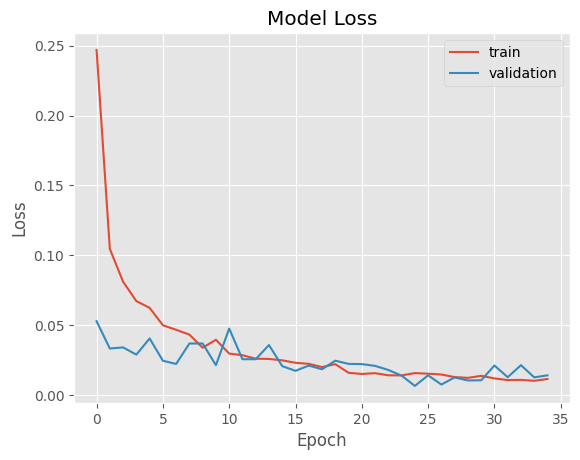

In [21]:
model = create_model(study.best_trial)
model.compile(optimizer=study.best_trial.params['optimizer'],
              loss='mse',
              metrics=['mean_squared_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(xTrain, yTrain, validation_split=0.15, epochs=study.best_trial.params['epochs'], verbose=0, callbacks=[early_stopping])

# Gráfica de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

De la grafica de pérdida se puede decir lo siguiente:
-  La pérdida en train disminuye en la primeras epocas, esto podria indicar el modelo aprende eficazmente las caracteristicas subyacentes de los datos.
-  Las fluctuaciones en el validación pueden indicar sobre-ajuste temporales por la inclusión de un Dropout, con las epocas se observa que las fluctuaciones van disminyendo por lo que es probable que se termine estabilizando y el uso del dropout ayude a generalizar el modelo en el conjunto de validación.
-   El uso de dropout en este modelo parece contribuir a la prevención del sobreajuste, como se evidencia por la reducción de la brecha entre la pérdida de entrenamiento y validación. Sin embargo, la magnitud de los picos de pérdida sugiere que el ratio de dropout o la distribución de los dropout podría necesitar ajustes para estabilizar aún más la pérdida durante el entrenamiento.
-  La presencia de picos en la pérdida de validación podría sugerir que un mecanismo de early stopping podría ser útil. Si el early stopping ya estaba implementado, podría ser beneficioso ajustar la paciencia del early stopping para que el entrenamiento se detenga antes, evitando así ciclos innecesarios de sobreajuste y mejora.

In [24]:
# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(xTest)
mae_multi_layer = mean_absolute_error(yTest, y_pred)
mse_multi_layer = mean_squared_error(yTest, y_pred)

print(f"MAE on Test Set: {mae_multi_layer}")
print(f"MSE on Test Set: {mse_multi_layer}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
MAE on Test Set: 0.06344700659116109
MSE on Test Set: 0.0057703631087446155


## Punto 4 - Comparación y análisis de resultados

En la celda 4 comparen los resultados obtenidos de las diferentes redes y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

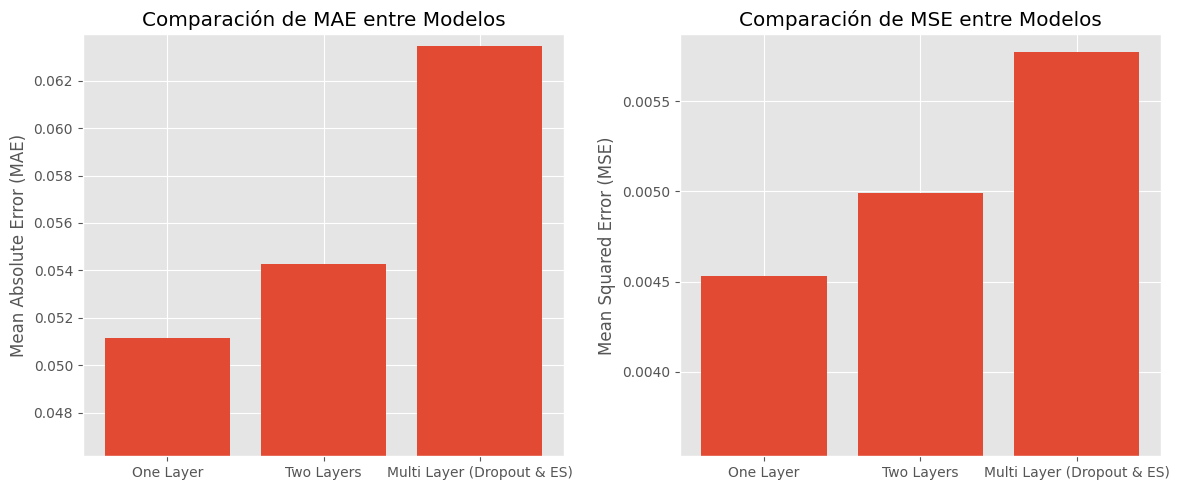

In [23]:
model_names = ['One Layer', 'Two Layers', 'Multi Layer (Dropout & ES)']

mae_values = [mae_one_layer, mae_two_layer, mae_multi_layer]
mse_values = [mse_one_layer, mse_two_layer, mse_multi_layer]

plt.figure(figsize=(12, 5))

# Gráfico para MAE
plt.subplot(1, 2, 1)  
plt.bar(model_names, mae_values)
plt.title('Comparación de MAE entre Modelos')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(min(mae_values) - 0.005, max(mae_values) + 0.0005) 

# Gráfico para MSE
plt.subplot(1, 2, 2)  
plt.bar(model_names, mse_values,)
plt.title('Comparación de MSE entre Modelos')
plt.ylabel('Mean Squared Error (MSE)')
plt.ylim(min(mse_values) - 0.001, max(mse_values) + 0.0001)  

plt.tight_layout()
plt.show()


De los resultados obtenidos se puede concluir lo siguiente:
-   **One Layer**: Muesta las métricas más bajas en compración con las demás lo cual indica que su desempeño es mejor en compración con los otros modelos.
-   **Modelo MultiLayers**: Muestra las métricas más altas en comparación con las demás lo cual indica un desempeño inferior en comparación con los otros dos modelos.

**Modelo One Layer**: Esta configuración mejora los resultados en comparación con los otros dos modelos, esto puede indicar que el modelo de una capa ayuda a capturar mejor la estructura de los datos, lo cual permite una mayor generalización y precisión. A pesar de su buen desempeño puede existir una tendencia al sobreajuste si el modelo se hace demasiado complejo, por ejemplo estudiando otros hiperparametros más a fondo, lo cual podria ser tratado utilizando un método de regularización como dropout que por ejemplo tienen el modelo de MultiLayers.

**Modelo Two Layers**: Esta configuración presenta el segundo mejor rendimiento, como se mencionaba puede existir una tendencia al sobreajuste si el modelo se hace demasiado complejo, lo cual es este caso, haciendo la red más compleja, los valores no mejoran sin que empeoran por lo que puede deberse a a que no es capaz de generalizar los nuevos datos. 

**Modelo MultiLayers**: Esta configuración obtiene el peor desempeño, entrenado incluso a la mitad del tiempo (<em>probablemente por el early stopping</em>), las técnicas de dropout y early stopping ayudan a prevenir el sobreajuste del modelo, en este caso estas técnicas ayudan a eliminar este posible sobreajuste desmejorando mucho los resultados del modelo. Es probable que tambien se deba realizar el ajuste del dropout (<em>que actualmente es del 30%</em>) para que este no sea tan agreviso y pueda de forma adecuada prevenir el sobreajuste. 